#KMEANS EURO VS DOLAR

##Instalamos estas dos librerias

In [1]:
!pip install fsspec
!pip install beautifulsoup4 

##

In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import preprocessing  #para normalizar los datos antes de aplicar al algoritmo
from sklearn.metrics import pairwise_distances_argmin_min

import matplotlib.pyplot as plt
import seaborn as sb
from mpl_toolkits.mplot3d import Axes3D   #para graficas en 3D

import requests                           # libreria para manejar pedidos internet
from bs4 import BeautifulSoup             # libreria para parsear documentos HTML

#from wikitables import import_tables    # para descargar tablas de Wikipedia
from sklearn.decomposition import PCA   # Análisis de componentes principales (PCA).

#configuraciones basicas para PLT
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

##Importando el dataset

In [453]:
df = pd.read_csv("https://raw.githubusercontent.com/2HenryCardenas1/DeepLearning/main/Datasets/(EUR-USD).csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-07-30,1.203804,1.211607,1.200495,1.201605,1.201605,0.0
1,2004-08-02,1.204195,1.209395,1.201995,1.202198,1.202198,0.0
2,2004-08-03,1.202198,1.207802,1.200206,1.205298,1.205298,0.0
3,2004-08-04,1.205298,1.206593,1.197504,1.205996,1.205996,0.0
4,2004-08-05,1.205894,1.207496,1.202993,1.205197,1.205197,0.0


#Observamos los datos del dataframe

In [454]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476 entries, 0 to 4475
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4476 non-null   object 
 1   Open       4427 non-null   float64
 2   High       4427 non-null   float64
 3   Low        4427 non-null   float64
 4   Close      4427 non-null   float64
 5   Adj Close  4427 non-null   float64
 6   Volume     4427 non-null   float64
dtypes: float64(6), object(1)
memory usage: 244.9+ KB


In [455]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4427.000000,4427.000000,4427.000000,4427.000000,4427.000000,4427.0
mean,1.258977,1.263661,1.253837,1.259005,1.259005,0.0
std,0.121000,0.121761,0.121624,0.120990,0.120990,0.0
min,1.039393,1.041992,0.072902,1.039047,1.039047,0.0
25%,1.155822,1.160732,1.151423,1.155956,1.155956,0.0
50%,1.258400,1.264095,1.252803,1.258606,1.258606,0.0
75%,1.345497,1.350749,1.340799,1.345497,1.345497,0.0
max,1.598184,1.602821,1.587402,1.598798,1.598798,0.0


In [456]:
df.isnull().sum()

Date          0
Open         49
High         49
Low          49
Close        49
Adj Close    49
Volume       49
dtype: int64

##Eliminamos y reseteamos el dataframe

In [457]:
df = df.dropna()   # Se eliminan filas que tengan valor NaN.
df = df.reset_index(drop=True) #Se reacomoda las filas en los espacios vacios para optimizacion de la memoria

###Cambiamos el Date a tipo de dato "date"

In [458]:
df['Date']=pd.to_datetime(df['Date'])  

###Verificamos los cambios

In [459]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4427 entries, 0 to 4426
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       4427 non-null   datetime64[ns]
 1   Open       4427 non-null   float64       
 2   High       4427 non-null   float64       
 3   Low        4427 non-null   float64       
 4   Close      4427 non-null   float64       
 5   Adj Close  4427 non-null   float64       
 6   Volume     4427 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 242.2 KB


In [460]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

##Definimos las variables a usar

In [461]:
df = df[['Date', 'Open', 'Close']]
df.head(10)

,Date,Open,Close
0,2004-07-30,1.203804,1.201605
1,2004-08-02,1.204195,1.202198
2,2004-08-03,1.202198,1.205298
3,2004-08-04,1.205298,1.205996
4,2004-08-05,1.205894,1.205197
5,2004-08-06,1.205705,1.230800
6,2004-08-09,1.226994,1.227295
7,2004-08-10,1.227807,1.223601
8,2004-08-11,1.223795,1.222195
9,2004-08-12,1.222195,1.223900


###Realizamos el resample 

---

https://stackoverflow.com/questions/57703538/typeerror-only-valid-with-datetimeindex-timedeltaindex-or-periodindex-but-got

In [462]:
#linea tomada de stackOverflow 
weekly_summary = df.resample('W', on='Date').sum()

In [463]:
weekly_summary.head

<bound method NDFrame.head of                 Open     Close
Date                          
2004-08-01  1.203804  1.201605
2004-08-08  6.023290  6.049489
2004-08-15  6.124796  6.134584
2004-08-22  6.180098  6.173796
2004-08-29  6.072298  6.043903
...              ...       ...
2021-08-29  5.872746  5.872598
2021-09-05  5.912787  5.912358
2021-09-12  5.924930  5.924960
2021-09-19  5.901099  5.901635
2021-09-26  5.861129  5.861101

[896 rows x 2 columns]>

###Creamos el metodo para graficar

In [464]:
def plot_stock(symbol, df_acciones=weekly_summary):
    df_acciones[symbol].plot(alpha=0.9);

###Graficamos

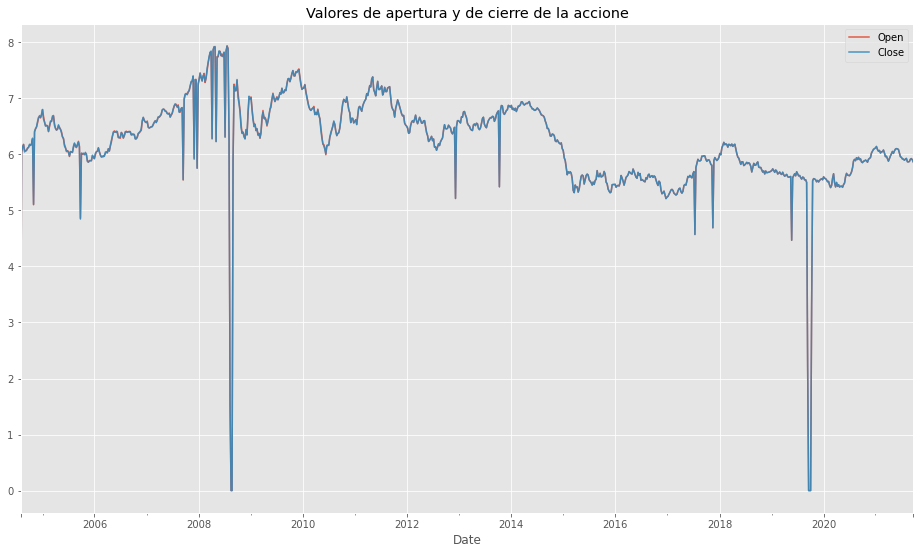

In [465]:
#Valor y cierre de las acciones
plot_stock('Open')#Open
plot_stock('Close')#Close
plt.title('Valores de apertura y de cierre de la accione')
plt.legend();

#Implementando KMEANS

##Normalizamos los datos

###Elimando datos nulos

In [466]:
df = df.dropna()
df = df.reset_index(drop=True)

In [467]:
# Eliminamos columna de fecha que no usaremos en el algoritmo.
dates = df['Date'] # Guardamos la columna Date.
df = df.drop('Date', 1) # Borramos la columna del dataframe.

In [468]:
#%% Se normalizan los datos con MinMax()
min_max_scaler = preprocessing.MinMaxScaler() 
df_escalado = min_max_scaler.fit_transform(df)
df_escalado = pd.DataFrame(df_escalado) # Hay que convertir a DF el resultado.
df_escalado = df_escalado.rename(columns = {0: 'Open', 1: 'Close', 2: 'High', 3: 'Low'})

In [469]:
df_escalado.head()
df_escalado.isnull().sum()

Open     0
Close    0
dtype: int64

##Representacion de los datos

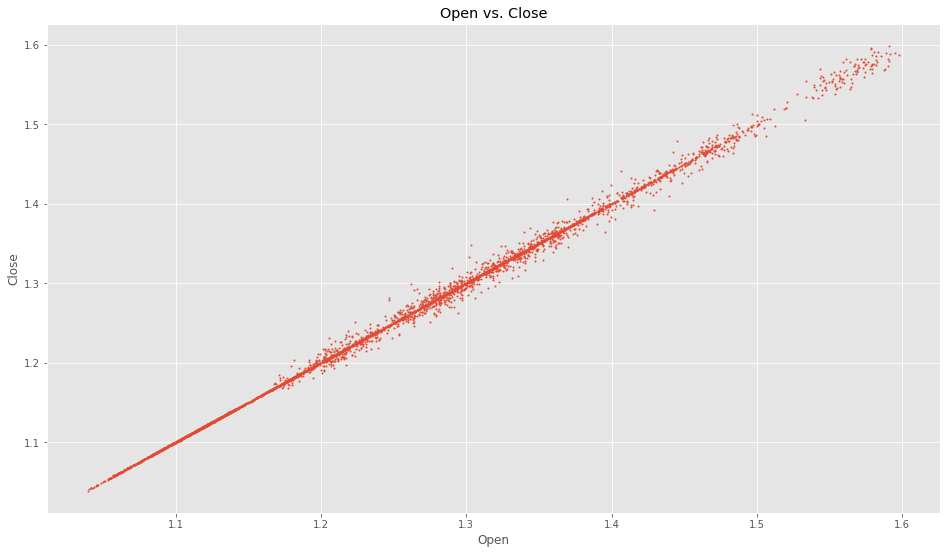

In [471]:
#%% Representación gráfica de los datos.
x = df['Open'].values
y = df['Close'].values
plt.xlabel('Open')
plt.ylabel('Close')
plt.title('Open vs. Close')
plt.plot(x,y,'o',markersize=1)

###Buscando el número de clústeres optimo

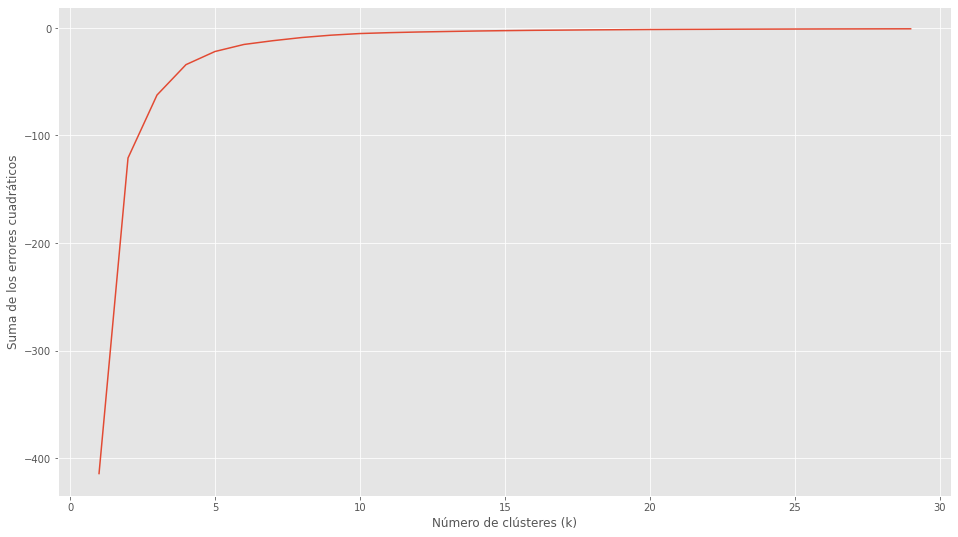

In [472]:
#%% Curva elbow para determinar valor óptimo de k.
nc = range(1, 30) # El número de iteraciones que queremos hacer.
kmeans = [KMeans(n_clusters=i) for i in nc]
score = [kmeans[i].fit(df_escalado).score(df_escalado) for i in range(len(kmeans))]
score
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Suma de los errores cuadráticos')
plt.plot(nc,score)

###Aplicamos el algoritmo de kmean

In [473]:
#%% Aplicación de k-means con k = 5.
kmeans = KMeans(n_clusters=5).fit(df_escalado)
centroids = kmeans.cluster_centers_
print(centroids)   

[[0.12509414 0.12554238]
 [0.59275112 0.59223458]
 [0.28762683 0.28786904]
 [0.80683776 0.80607394]
 [0.45376828 0.45375777]]


##Creamos nuestras etiquetas

In [474]:
labels = kmeans.predict(df_escalado)   #generamos las etiquetas de cada clouster
df['label'] = labels                   

df.insert(0, 'Date', dates)           

In [475]:
df.head(10)

,Date,Open,Close,label
0,2004-07-30,1.203804,1.201605,2
1,2004-08-02,1.204195,1.202198,2
2,2004-08-03,1.202198,1.205298,2
3,2004-08-04,1.205298,1.205996,2
4,2004-08-05,1.205894,1.205197,2
5,2004-08-06,1.205705,1.230800,2
6,2004-08-09,1.226994,1.227295,2
7,2004-08-10,1.227807,1.223601,2
8,2004-08-11,1.223795,1.222195,2
9,2004-08-12,1.222195,1.223900,2


##Representación gráfica de los clústeres k-means

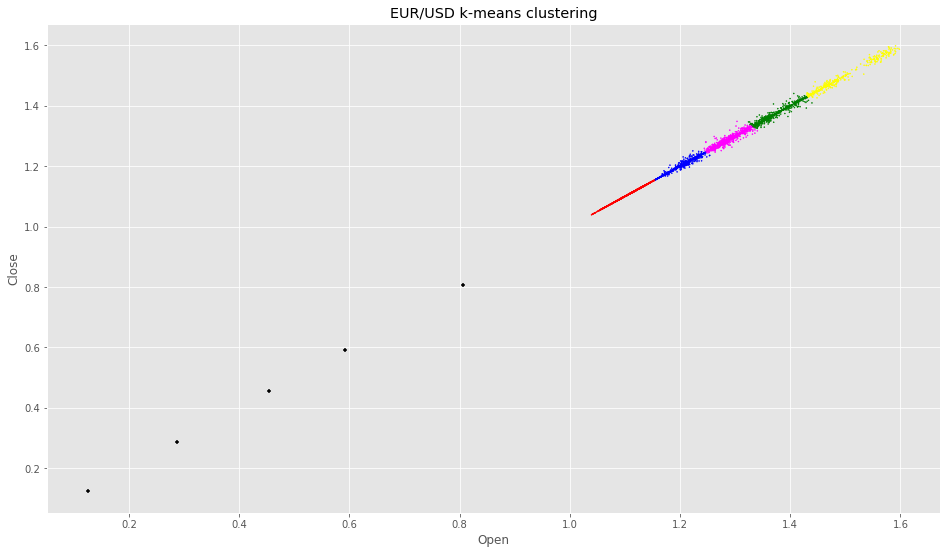

In [476]:
#%% Plot k-means clustering.
colores=['red','green','blue','yellow','fuchsia']
asignar=[]
for row in labels:
     asignar.append(colores[row])
plt.scatter(x, y, c=asignar, s=1)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='+', c='black', s=20) # Marco centroides.
plt.xlabel('Open')
plt.ylabel('Close')
plt.title('EUR/USD k-means clustering')
plt.show()

##Grupos y centroides

In [477]:
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['blue','red','green','yellow','cyan']
asignar=[]
for row in labels:
    asignar.append(colores[row])

In [480]:
f1 = df['Open'].values
f2 = df['Close'].values


###Graficas

###Open en X y Close en Y

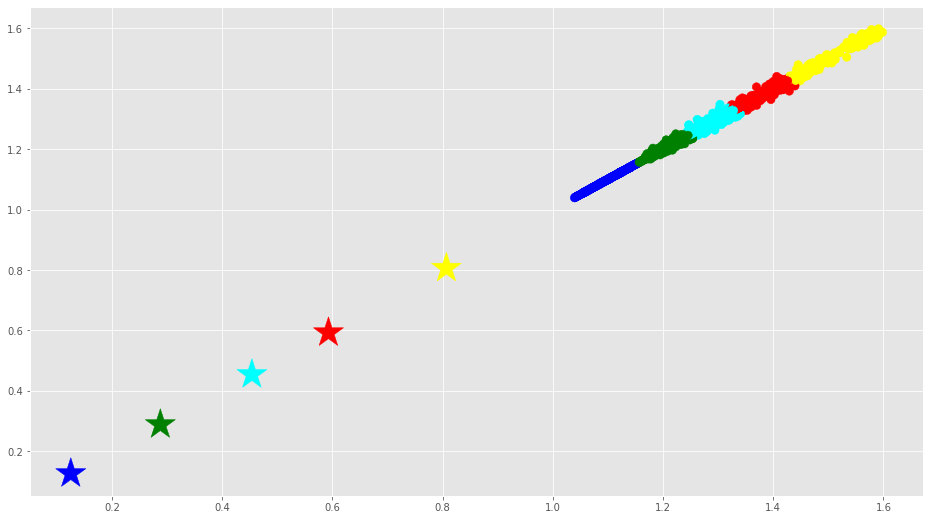

In [481]:
plt.scatter(f1, f2, c=asignar, s=70)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=1000)
plt.show()

###Close en X y Open en Y 

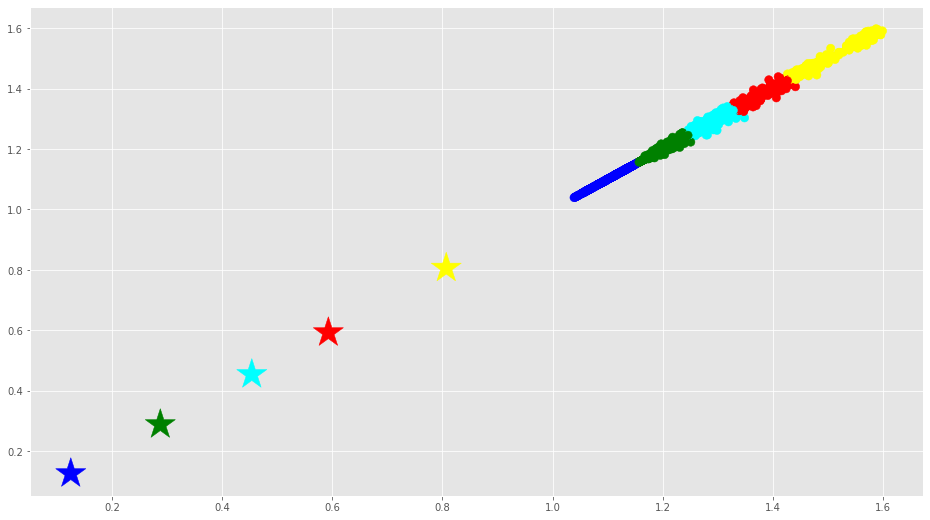

In [482]:
plt.scatter(f2, f1, c=asignar, s=70)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=1000)
plt.show()

In [483]:
copy =  pd.DataFrame()
copy['Open']=df['Open'].values
copy['Close']=df['Close'].values
copy['label'] = labels;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores
cantidadGrupo['cantidad']=copy.groupby('label').size()
cantidadGrupo

,color,cantidad
0,blue,1101
1,red,900
2,green,1019
3,yellow,389
4,cyan,1018
